## Import ##

In [1]:
import numpy as np
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score

import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# augmentations
from torchvision.transforms import RandomResizedCrop, RandomRotation, GaussianBlur, RandomApply, RandomAdjustSharpness, RandomAutocontrast, RandAugment

In [2]:
torch.manual_seed(1)

In [3]:
dvc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dvc

device(type='cuda')

## Data ##

Our data for classifier is dogs_vs_cats dataset. We can write custom dataset for this for out-memory reading and working.

Link:
https://www.kaggle.com/c/dogs-vs-cats

In [5]:
path_to_train_data = 'A:\\My files\\Datasets\\dogs-vs-cats\\train\\train'
path_to_test_data = 'A:\\My files\\Datasets\\dogs-vs-cats\\test1\\test1'

Parent Animal Data

In [6]:
class MyAnimalsData(Dataset):
    def __init__(self, path_to_train_data: str, input_shape = 277, transform: list = None, random_augment: bool = False):
        self.path_to_train_data = path_to_train_data
        self.input_shape = input_shape
        self.transform = transform
        self.random_augment = random_augment
        
    def __len__(self) -> int:
        return len( os.listdir( self.path_to_train_data ) )
    
    def __getitem__(self, idx):
        #img = cv2.imread( os.path.join(self.path_to_train_data, os.listdir( self.path_to_train_data )[idx] ) )
        img = Image.open( os.path.join(self.path_to_train_data, os.listdir( self.path_to_train_data )[idx] ) )
        label = str(os.listdir( self.path_to_train_data )[idx])[:3]
        composed = self.transform(img)
        
        if (self.random_augment):
            random_transform = Compose([RandomResizedCrop(self.input_shape), GaussianBlur(3), RandomAutocontrast()])
            composed = random_transform(composed)
        if (label == 'cat'):
            label = torch.Tensor([0, 1])
        else: 
            label = torch.Tensor([1, 0])
        return composed, label

Check

In [7]:
test = MyAnimalsData(path_to_train_data, transform = transforms.Compose([Resize(size = (277, 277)), ToTensor()]))

In [8]:
(np.transpose((next(iter(test))[0]).detach().numpy(), (1,2,0)).min(), 
np.transpose((next(iter(test))[0]).detach().numpy(), (1,2,0)).max(), )
# normilized data

(0.0, 1.0)

tensor([0., 1.])


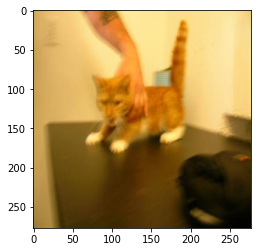

In [9]:
plt.imshow(np.transpose(next(iter(test))[0].detach().numpy(), (1,2,0)))
print(next(iter(test))[1])

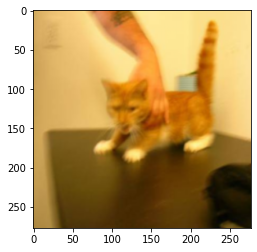

In [10]:
trn = MyAnimalsData(path_to_train_data, transform = transforms.Compose([Resize(size = (277,277)), ToTensor()]), random_augment = True)
plt.imshow(np.transpose(next(iter(trn))[0].detach().numpy(), (1,2,0)))

All works

## Dataset ##

In [11]:
Train_data = DataLoader( trn, batch_size = 64, shuffle = True )

(277, 277, 3)
tensor([1., 0.])


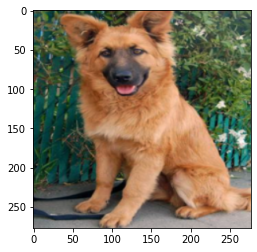

In [36]:
for X,y in Train_data:
    print(np.transpose( X.detach().numpy()[0], (1,2,0) ).shape)
    print( y[0], )
    plt.imshow( np.transpose(X.detach().numpy()[0], (1,2,0) ) )
    break

All works. Now we can initialize train and test data

We need validation data. Use random_split.

In [37]:
train_dataset, val_dataset = torch.utils.data.random_split(trn, lengths = [int(round(len(trn)*0.7)), int(round(len(trn)*0.3))])

In [38]:
len(train_dataset), len(val_dataset)

(17500, 7500)

In [39]:
Train_loader, Val_loader = DataLoader(train_dataset, batch_size = 64), DataLoader(val_dataset, batch_size = 64)

Test data

In [7]:
Test_dataset = MyAnimalsData(path_to_test_data, transform = transforms.Compose([Resize(size = (277,277)), ToTensor()]), random_augment = False)

In [8]:
Test_data = DataLoader( Test_dataset, batch_size = 64, shuffle = True )

(277, 277, 3)
tensor([1., 0.])


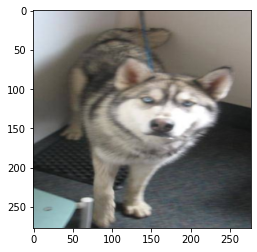

In [9]:
for X,y in Test_data:
    print(np.transpose( X.detach().numpy()[0], (1,2,0) ).shape)
    print( y[0], )
    plt.imshow( np.transpose(X.detach().numpy()[0], (1,2,0) ) )
    break

## Model ##

In [9]:
class SimpleConvNet(nn.Module):
    def __init__(self, input_size, b1_output_feat = 8, b2_output_feat = 16,):
        super(SimpleConvNet, self).__init__()
        self.Block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 3, kernel_size = 1, padding=0), 
            nn.Conv2d(in_channels = 3,out_channels = b1_output_feat, kernel_size = 3, padding=0), 
            nn.BatchNorm2d(num_features=b1_output_feat), nn.ReLU(True))
        # shape = (batch_size, input_size - 2, input_size - 2, b1_output_feat)
        
        self.Block2 = nn.Sequential(
            nn.Conv2d(in_channels = b1_output_feat, out_channels = b1_output_feat,kernel_size = 1, padding=0), 
            nn.Conv2d(in_channels = b1_output_feat,out_channels = b2_output_feat,kernel_size = 5, padding=0), 
            nn.BatchNorm2d(num_features = b2_output_feat), nn.ReLU(True), nn.MaxPool2d(kernel_size = 3, stride = 1))
        # shape = (batch_size, input_size - 4 - 2, input_size - 4 - 2, b2_output_feat)
        
        # common shape after block 1 and 2 = (batch_size, input_size - 2 - 4 - 2, input_size - 2 - 4 - 2, b2_output_feat)
        
        self.Classifier_block = nn.Sequential(nn.Linear( in_features = ((input_size[0] - 8) * (input_size[1] - 8) * b2_output_feat), out_features = 50), 
                                              nn.Linear(in_features = 50, out_features = 2),
                                              #nn.Softmax(2) # use BCElogits instead for gradients flow
                                             )
    def forward(self, x):
        x = self.Block1(x)
        x = self.Block2(x)
        x = x.view(x.size(0), torch.prod(torch.tensor(x.size()[1:])))
        
        x = self.Classifier_block(x)
        return x

Create instance

In [14]:
Sample_model = SimpleConvNet(input_size = (277, 277), )

In [44]:
Sample_model.to(dvc)

SimpleConvNet(
  (Block1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (Block2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier_block): Sequential(
    (0): Linear(in_features=1157776, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=2, bias=True)
  )
)

Opt and Loss

In [45]:
Opt = torch.optim.SGD(params = Sample_model.parameters(), lr = 0.001, )

In [46]:
Loss = nn.BCEWithLogitsLoss()

## Train-loop routine ##

In [10]:
def train_model(model, Opt, Loss, batch_size, epochs, Train_loader, Val_loader):
    epoch_loss_train = []
    epoch_loss_val = []
    for epoch in range(0, epochs, 1):
        model.train()
        tr_loss = []
        val_loss = []
        with tqdm_notebook(Train_loader) as tq_data:
            for i, (X,y) in enumerate(tq_data):
                tq_data.set_description(f"Epoch {epoch}, Step = {i * batch_size}/{len(Train_loader) * batch_size}")
                X = X.to(dvc)
                y = torch.Tensor(y).to(dvc)
                Opt.zero_grad()
                op = model(X)
                step_loss = Loss(op, y)
                step_loss.backward()
                Opt.step()

                tr_loss.append(step_loss.item())
                
                best = np.min(tr_loss)
                tq_data.set_postfix(loss = tr_loss[-1], best_in_epoch = best)
        model.eval()
        with torch.no_grad():
            with tqdm_notebook(Val_loader) as tq_val_data:
                for i, (X,y) in enumerate(tq_val_data):
                    tq_val_data.set_description(f"Epoch {epoch}, Step = {i * batch_size}/{len(Val_loader) * batch_size}")
                    X = X.to(dvc)
                    y = torch.Tensor(y).to(dvc)
                    op = model(X)
                    step_loss = Loss(op, y)
                    val_loss.append(step_loss.item())
                    tq_val_data.set_postfix(loss = val_loss[-1], best_in_epoch = best)
                    
        epoch_loss_train.append(np.array(tr_loss).mean())
        epoch_loss_val.append(np.array(val_loss).mean())
    return epoch_loss_train, epoch_loss_val

## All ##

In [12]:
bs = 64
i_s = (277,277)

In [18]:
trn = MyAnimalsData(path_to_train_data, transform = transforms.Compose([Resize(size = i_s), ToTensor()]), random_augment = True)
Train_data = DataLoader( trn, batch_size = bs, shuffle = True )
train_dataset, val_dataset = torch.utils.data.random_split(trn, lengths = [int(round(len(trn)*0.7)), int(round(len(trn)*0.3))])
Train_loader, Val_loader = DataLoader(train_dataset, batch_size = bs), DataLoader(val_dataset, batch_size = bs)

Sample_model = SimpleConvNet(input_size = i_s,)
Sample_model.to(dvc)
Opt = torch.optim.SGD(params = Sample_model.parameters(), lr = 0.001, )
Loss = nn.BCEWithLogitsLoss()

In [11]:
train_model(model = Sample_model, Opt = Opt, batch_size= bs, Loss = Loss, epochs = 3, Train_loader = Train_loader, Val_loader = Val_loader)

c:\python\python36\tf\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/293 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\python\python36\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f4af3133149c>", line 1, in <module>
    train_model(model = Sample_model, Opt = Opt, batch_size= bs, Loss = Loss, epochs = 3, Train_loader = Train_loader, Val_loader = Val_loader)
  File "<ipython-input-8-dc74c61f38ed>", line 11, in train_model
    X = X.to(dvc)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\python\python36\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Python\Python36\lib\linecache.py", line 74, in c

TypeError: object of type 'NoneType' has no len()

In [19]:
Train_metrics, Val_metrics = _

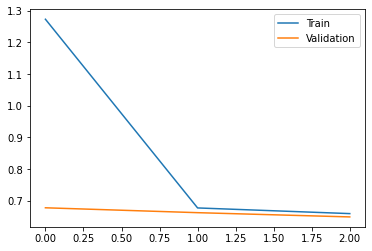

In [23]:
plt.plot(Train_metrics, label = 'Train')
plt.plot(Val_metrics, label = 'Validation')
plt.legend()

In [50]:
torch.save(Sample_model.state_dict(), 'model_state/mdl')

Open weights

In [19]:
Sample_model = SimpleConvNet(input_size = i_s,)
Sample_model.to(dvc)

SimpleConvNet(
  (Block1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (Block2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier_block): Sequential(
    (0): Linear(in_features=1157776, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [20]:
Sample_model.load_state_dict(torch.load('model_state/mdl'))

<All keys matched successfully>

In [21]:
Sample_model.named_parameters

<bound method Module.named_parameters of SimpleConvNet(
  (Block1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (Block2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier_block): Sequential(
    (0): Linear(in_features=1157776, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=2, bias=True)
  )
)>

Now we can use forward step in our network and check it

In [ ]:
from torch.me

In [22]:
def test_net(model, loader):
    ind_to_label = {0:'dog', 1:'cat'}
    model.eval()
    labels = []
    res = []
    with torch.no_grad():
        with tqdm_notebook(Val_loader) as tq_val_data:
            for i, (X,y) in enumerate(tq_val_data):
                
                X = X.to(dvc)
                y = torch.Tensor(y).to(dvc)
                
                op = model(X)
                prob = torch.sigmoid(op)
                
                classes = prob.argmax(axis = 1)
                y = y.argmax(axis = 1)
                
                res.append(classes)
                labels.append(y)
                #print(classes, y)
        
        res = [r.cpu().detach().numpy() for r in res]
        labels = [l.cpu().detach().numpy() for l in labels]
        return res, labels

In [27]:
r,l = test_net(Sample_model, train_dataset)

c:\python\python36\tf\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/118 [00:00<?, ?it/s]

In [41]:
r_flattened = np.concatenate(r).ravel()
l_flattened = np.concatenate(l).ravel()

In [ ]:
acc = accuracy_score(r_flattened,l_flattened)
acc

0.6281333333333333

Let's look at this

In [47]:
test_iterator = iter(Test_data)
test_sample, test_labels = next(test_iterator)

In [48]:
with torch.no_grad():
    op = Sample_model(test_sample.to(dvc))

In [49]:
logits_to_prob = torch.sigmoid(op)

In [50]:
logits_to_prob

tensor([[0.4096, 0.5635],
        [0.5931, 0.4088],
        [0.8303, 0.1560],
        [0.6271, 0.4155],
        [0.5979, 0.3622],
        [0.5565, 0.4511],
        [0.5660, 0.4178],
        [0.5112, 0.4949],
        [0.7041, 0.2732],
        [0.5001, 0.4845],
        [0.8014, 0.1536],
        [0.5801, 0.4125],
        [0.7596, 0.2402],
        [0.3271, 0.6716],
        [0.4681, 0.5409],
        [0.3809, 0.5654],
        [0.5315, 0.4193],
        [0.9539, 0.0388],
        [0.4891, 0.5373],
        [0.3900, 0.6316],
        [0.5023, 0.5194],
        [0.3860, 0.6027],
        [0.5662, 0.4365],
        [0.5464, 0.4376],
        [0.6197, 0.3861],
        [0.5948, 0.4120],
        [0.5159, 0.4775],
        [0.6545, 0.3268],
        [0.1772, 0.8414],
        [0.8352, 0.1755],
        [0.4055, 0.6095],
        [0.7502, 0.2501],
        [0.6114, 0.3953],
        [0.4926, 0.5198],
        [0.5909, 0.3948],
        [0.5929, 0.4417],
        [0.6951, 0.2966],
        [0.5583, 0.4582],
        [0.4

 - [1., 0.] or 0 is a dog (argmax([1,0]) = 0)
 - [0., 1.] is 1 a cat (argmax([0,1]) = 1)

In [51]:
ind_to_label = {0:'dog', 1:'cat'}
res = np.vectorize(ind_to_label.get)(logits_to_prob.argmax(axis = 1).cpu().detach().numpy())

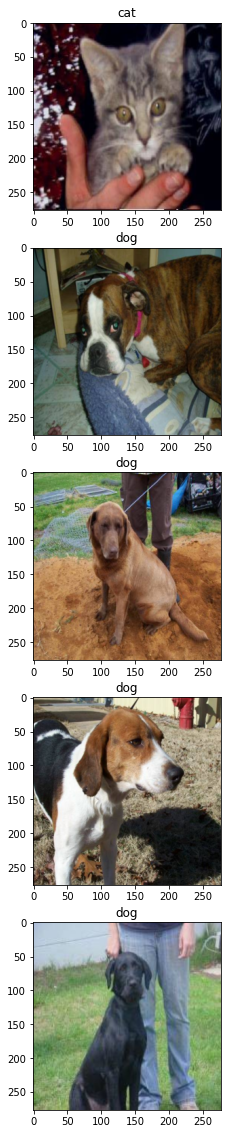

In [52]:
ind = 5
fig, ax = plt.subplots(ind, figsize = (15,20))
for j, (img, pred) in enumerate(zip(test_sample.detach().numpy()[:ind], res)):
    ax[j].imshow(np.transpose(img, (1,2,0)))
    ax[j].set_title(str(pred))